In [1]:
import network as nw
import numpy as np 
from scipy.sparse import csr_matrix
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(1)

In [2]:
#collecting data from csv file
data = np.genfromtxt("connections.csv", delimiter=",")
#matrix dimension
N = int(np.max(data)) + 1
#generating the sparse matrix from data
A = csr_matrix((np.ones(len(data)), (data[:, 0], data[:, 1])), shape = (N, N), dtype = np.int32)
#making the network undirected
A = A + A.T
A_w = A
#removing multilinks
A = 1*(A > 0)

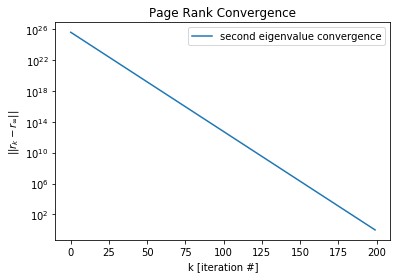

In [3]:
#I want an error that is around 1e-15 so i check the convergence of power iteration
#to find out the number of iterations needed
d = 1 / nw.get_degrees(A)
M = A * sp.sparse.diags(d[:, 0])
v = nw.get_two_highest_eigenvalues(M)
v2 = v[1]

plt.title("Page Rank Convergence")
ind = np.arange(200)
ref = (0.85*np.abs(v2))**ind
plt.semilogy(ind, ref/ref[-1])
plt.xlabel("k [iteration #]")
plt.ylabel(r"$||r_k - r_\infty||$")
plt.legend(["second eigenvalue convergence"])


In [4]:
#from the previous graph the error is reduced by a factor o 1e15 
#after more or less 125 iterations
num_iter = 125
p = nw.page_rank_power_iteration(A, iter_num = num_iter)

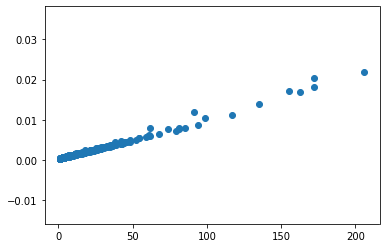

In [5]:
d = nw.get_degrees(A)
plt.scatter(d, p)

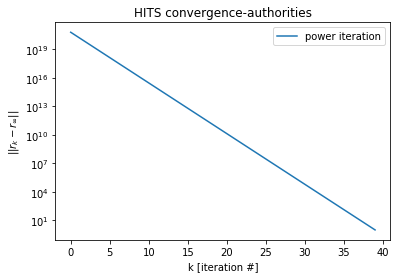

In [6]:
#I want an error that is around 1e-15 so i check the convergence of power iteration
#to find out the number of iterations needed
v = nw.get_two_highest_eigenvalues(A*A.T)

plt.figure()
plt.title("HITS convergence-authorities")
ind = np.arange(40)
ref = np.abs(v[1]/v[0])**ind
plt.semilogy(ind, ref/ref[-1])
plt.xlabel("k [iteration #]")
plt.ylabel(r"$||r_k - r_\infty||$")
plt.legend(["power iteration", "second eigenvalue"])


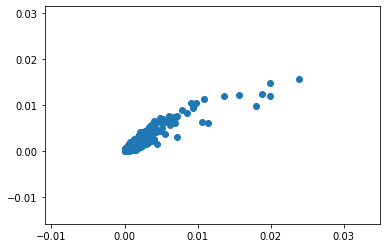

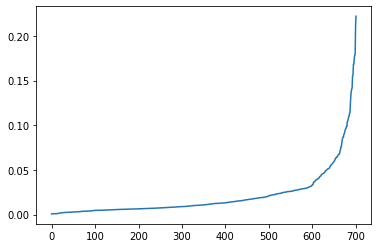

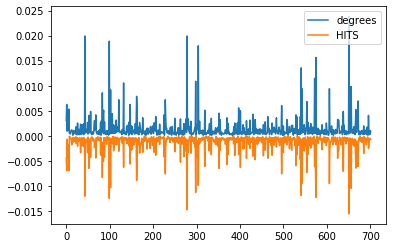

In [7]:
#i see that 40 iterations reduce the error by a reasonable amount
num_iter = 40

r = nw.hits_power_iteration(A, iter_num=num_iter)
d = d/np.sum(d)
plt.scatter(d, r/np.sum(r))
plt.figure()
plt.plot(np.sort(r-p, axis=0))
plt.figure()
plt.plot(d)
plt.plot(-r/np.sum(r))
plt.legend(["degrees", "HITS"])

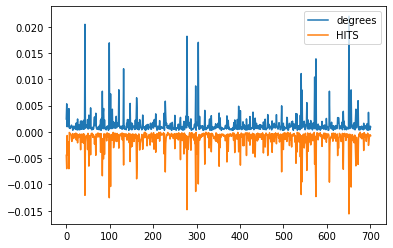

In [8]:
plt.plot(p)
plt.plot(-r/np.sum(r))
plt.legend(["degrees", "HITS"])

In [9]:
#array that contains the name of each character so it's index is it's id
characters_id = []

#reading from file
with open("nodes.csv", "r") as fp:
    for line in fp:
        #for each line get name and id
        name, name_ID = line.replace("\n", "").split(",")
        characters_id.append(name)

In [10]:
#index that would sort from less ranked to most ranked with hits and normal degrees
ids_r = np.argsort(r, axis = 0)
ids_d = np.argsort(d, axis = 0)

#ranking based on the rank difference obtained with the two ranking methods
ids_rd = np.argsort(r-d, axis = 0)

#positions in the ranking the one with the highest rank is assigned position 0
positions = np.arange(N)[::-1]

#getting the position of each character with both rankings
position_d = positions[np.argsort(ids_d, axis = 0)]
position_r = positions[np.argsort(ids_r, axis = 0)]

#points = position
#scores = 
#increment in position with HITS rank compared with the other
delta_pos = position_d - position_r
ids_delta = np.argsort(delta_pos, axis = 0)
characters_r = [characters_id[i[0]] for i in ids_r[::-1]]
characters_d = [characters_id[i[0]] for i in ids_d[::-1]]
characters_rd = [characters_id[i[0]] for i in ids_delta[::-1]]
pos_d = [position_d[i[0]][0] for i in ids_delta[::-1]]
pos_r = [position_r[i[0]][0] for i in ids_delta[::-1]]
pd_dict = {
    "HITS":characters_r, 
    "deg":characters_d
}
pd_imp_dict = {
    "character_improvement":characters_rd,
    "improvement": np.sort(delta_pos, axis = 0)[::-1,0],
    "d_pos": pos_d,
    "r_pos": pos_r

}
df = pd.DataFrame(pd_dict)
df_imp = pd.DataFrame(pd_imp_dict)

In [11]:
df_imp[(df_imp["r_pos"] < 10) | (df_imp["d_pos"] < 10)]

,character_improvement,improvement,d_pos,r_pos
357,Cersei Lannister,5,13,8
364,Tywin Lannister,3,10,7
371,Joffrey Baratheon,2,8,6
374,Sansa Stark,2,5,3
379,Robb Stark,1,6,5
383,Catelyn Stark,1,3,2
389,Tyrion Lannister,0,0,0
390,Jaime Lannister,0,1,1
394,Arya Stark,-2,2,4
400,Jon Snow,-5,4,9


In [12]:
df.head()

,HITS,deg
0,Tyrion Lannister,Tyrion Lannister
1,Jaime Lannister,Jaime Lannister
2,Catelyn Stark,Arya Stark
3,Sansa Stark,Catelyn Stark
4,Arya Stark,Jon Snow


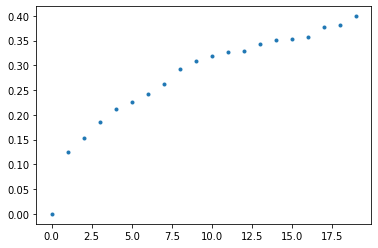

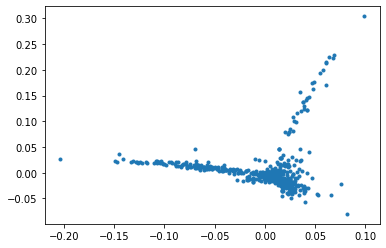

In [13]:
D = nw.get_D_matrix(A)
L = sp.sparse.identity(N) - D*A*D

#getting the eigenvectors of L
eig_val, eig_vec = np.linalg.eigh(L.toarray())
plt.plot(eig_val[0:20], linestyle="None", marker = ".")
plt.figure()
plt.plot(eig_vec[:, 1], eig_vec[:, 2], linestyle="None", marker = ".")

In [14]:
def print_community(community, character_id):
    print([character_id[idx] for idx in community])

In [15]:
#communities, modularities = nw.kmeans_clustering(A)
#print(nw.get_modularity(A, communities))
#plt.plot(modularities)

In [16]:
#spectral_clustering_reordering if division with spectral clustering is to be performed
#suggested conductance_lim = 0.25 for spectral and 0.44 for page nibble
f = nw.spectral_clustering_reordering

communities, separators = nw.divide_in_communities(A, f, conductance_lim=0.25)
print(len(communities))

15


In [17]:
i = 14
print(f'community index = {communities[i]["path"]}')
print(f"community")
chara = communities[i]["indexes"]
chara.sort()
print_community(chara, characters_id)
print(f"borderline character = {characters_id[communities[i]['border']]}")

community index = 111
community
['Aethan', 'Alan', 'Bannen', 'Bedwyck', 'Benjen Stark', 'Bernarr', 'Blane', 'Byam', 'Chett', 'Craster', 'Donnel Hill', 'Dywen', 'Edd Tollett', 'Fornio', 'Garth', 'Goady', 'Grubbs', 'Karl', 'Kedge Whiteye', 'Lew', 'Maester Harmune', 'Mallador Locke', 'Maslyn', 'Mawney', 'Nella', 'Ollo Lophand', 'Oss', 'Ottyn Wythers', 'Small Paul', 'Rolley', 'Ronnel Harclay', 'Ryles', 'Sam Tarly', 'Sawwood', 'Lark Sisterman', 'Softfoot', 'Thoren Smallwood', 'Tim Stone', 'Tumberjon', 'Waymar Royce']
borderline character = Sam Tarly


In [18]:
import warnings
from scipy.sparse import SparseEfficiencyWarning

#ignoring sparse efficiency warning because in this case it is not more efficient to use a lil_matrix
warnings.simplefilter('ignore',SparseEfficiencyWarning)

armies = {
    "Daenerys": communities[0]["indexes"],
    "Stannis": communities[1]["indexes"],
    "Lannisters": np.concatenate([communities[2]["indexes"], communities[5]["indexes"]],axis=0),
    "Robb": communities[10]["indexes"],
    "Free Folks": communities[11]["indexes"],
    "Night's watch": np.concatenate([communities[13]["indexes"], communities[14]["indexes"]],axis=0)
}

def check_army_robustness(A, army, ax, name):

    A1 = A[army.reshape(-1), :][:, army.reshape(-1)]
    N = A1.shape[0]
    
    #getting parameters from random and hubs removal
    random_removal, attack_removal = nw.check_robustness(A1)
    
    #getting the GC dimensions
    random = np.array(random_removal[0])/N
    attack = np.array(attack_removal[0])/N

    #getting the breaking points
    break_random = np.argmax(random < 0.05)
    break_attack = np.argmax(attack < 0.05)
    
    #print(f"For random removal inhomogeneity ratio goes below 2 when f = {inh_random/N}")
    #print(f"For attack removal inhomogeneity ratio goes below 2 when f = {inh_attack/N}")

    ax.plot(np.linspace(0, 1, N), random)
    ax.plot(np.linspace(0, 1, N), attack)
    ax.plot(np.linspace(0, 1, N),np.arange(N, 0, -1)/N)
    ax.vlines(break_random/N, 0, 0.1, colors="darkblue")
    ax.vlines(break_attack/N, 0, 0.1, colors="red")
    ax.set_xlabel("f")
    ax.set_title(f"Robustness for the army of {name}")
    ax.legend([
        "Random removal", 
        "Hubs removal", 
        "# of nodes", 
    ])
    ax.set_ylabel("$P_\infty(f)/P_\infty(0)$")


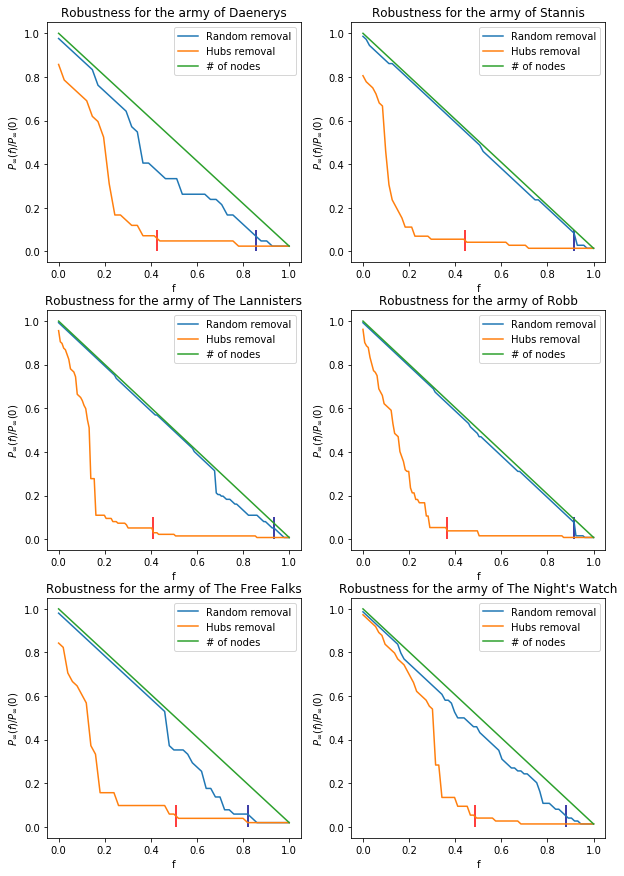

In [19]:
fig, axs = plt.subplots(3,2, figsize=(10,15))
check_army_robustness(A, armies["Daenerys"], axs[0, 0], "Daenerys")
check_army_robustness(A, armies["Stannis"], axs[0, 1], "Stannis")
check_army_robustness(A, armies["Lannisters"], axs[1, 0], "The Lannisters")
check_army_robustness(A, armies["Robb"], axs[1, 1], "Robb")
check_army_robustness(A, armies["Free Folks"], axs[2, 0], "The Free Falks")
check_army_robustness(A, armies["Night's watch"], axs[2, 1], "The Night's Watch")

In [20]:
def get_sep_tree(separators, path=""):
    if len(separators) == 3:
        print(f"{characters_id[separators[1]]}, path:{path}")
        get_sep_tree(separators[0] ,path+"0")
        get_sep_tree(separators[2], path+"1")
    elif len(separators) == 1:
        print(f"{characters_id[separators[0]]}, path:{path}")
    elif len(separators) == 2 and type(separators[0]) == np.int64:
        print(f"{characters_id[separators[0]]}, path:{path}")
        get_sep_tree(separators[1], path+"1")
    else:
        print(f"{characters_id[separators[1]]}, path:{path}")
        get_sep_tree(separators[0], path+"0")
get_sep_tree(separators)

Gage, path:
Lyonel Selmy, path:0
Merry Crane, path:01
Stafford, path:010
Aerion Brightflame, path:0100
Arys Oakheart, path:0101
Bessa, path:01011
Nage, path:011
Megga, path:0110
Nage, path:01101
Garse Goodbrook, path:0111
Jarman Buckwell, path:1
Jeor Mormont, path:11
Knott, path:110


In [21]:
auc_roc = {}
precision = {}

In [22]:
rwwr = "Random walk with restart"
lrw = "Local random walk"
srw = "Superposed random walk"
cn = "Common neighbours"
aa = "Adamic Adar"
ra = "Resource Allocation"

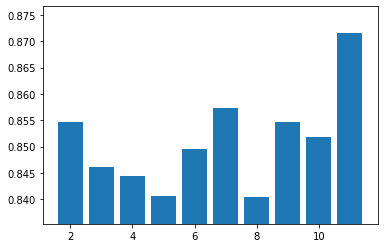

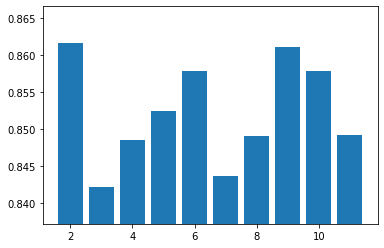

In [23]:
auc_roc[rwwr] = nw.ROC_AUC(A, nw.random_walk_with_restart_link_prediction)
precision[rwwr] = nw.precision(A, nw.random_walk_with_restart_link_prediction)

roc_aucs = []
t_range = range(2, 12)
for t in t_range:
    roc_aucs.append(nw.ROC_AUC(A, nw.local_random_walk_link_prediction, [t]))

roc_aucs = np.array(roc_aucs)
plt.bar(t_range, roc_aucs )
plt.ylim([np.min(roc_aucs) - 0.005, np.max(roc_aucs) + 0.005])
best_t = [t_range[np.argmax(np.array(roc_aucs))]]
auc_roc[lrw] = nw.ROC_AUC(A, nw.local_random_walk_link_prediction, best_t)
precision[lrw] = nw.precision(A, nw.local_random_walk_link_prediction, best_t)

roc_aucs = []
for t in t_range:
    roc_aucs.append(nw.ROC_AUC(A, nw.superposed_random_walk_link_prediction, [t]))

plt.figure()
roc_aucs = np.array(roc_aucs)
plt.bar(t_range, roc_aucs )
plt.ylim([np.min(roc_aucs)-0.005, np.max(roc_aucs)+0.005])
best_t = [t_range[np.argmax(np.array(roc_aucs))]]
auc_roc[srw] = nw.ROC_AUC(A, nw.superposed_random_walk_link_prediction, best_t)
precision[srw] = nw.precision(A, nw.superposed_random_walk_link_prediction, best_t)

In [24]:
auc_roc[cn] = nw.ROC_AUC(A, nw.common_neigh_link_prediction)
precision[cn] = nw.precision(A, nw.common_neigh_link_prediction)
auc_roc[aa] = nw.ROC_AUC(A, nw.adamic_adar_link_prediction)
precision[aa] = nw.precision(A, nw.adamic_adar_link_prediction)
auc_roc[ra] = nw.ROC_AUC(A, nw.resource_allocation_link_prediction)
precision[ra] = nw.precision(A, nw.resource_allocation_link_prediction)

In [25]:
l = range(2, 7)
beta = [0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001]
katz_res = np.zeros((len(l), len(beta)))
for i, l_i in enumerate(l):
    for j, b in enumerate(beta):
        roc_auc = nw.ROC_AUC(A, nw.katz_link_prediction, (l_i, b))
        katz_res[i, j] = roc_auc

(5.0, 0.0)

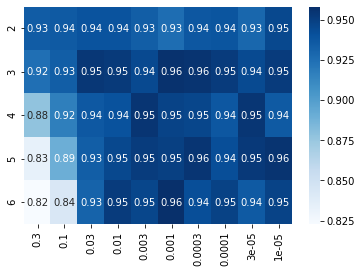

In [26]:
import seaborn as sns
ax = sns.heatmap(katz_res, cmap = "Blues", xticklabels=beta, yticklabels=l, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [27]:
rows, cols = np.unravel_index(np.argmax(katz_res), katz_res.shape)
print(l[rows], beta[cols])

6 0.001


In [28]:
auc_roc["katz"] = nw.ROC_AUC(A, nw.katz_link_prediction, (l[rows], beta[cols]))
precision["katz"] = nw.precision(A, nw.katz_link_prediction, (l[rows], beta[cols]))

In [29]:
df = pd.DataFrame({"AUC_ROC":auc_roc, "Precision":precision})
df.head(10)

,AUC_ROC,Precision
Random walk with restart,0.976680,0.264501
Local random walk,0.868111,0.032483
Superposed random walk,0.848153,0.067285
Common neighbours,0.946134,0.169374
Adamic Adar,0.939845,0.276102
Resource Allocation,0.969125,0.380510
katz,0.961762,0.199536


In [30]:
df.to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n{} &   AUC\\_ROC &  Precision \\\\\n\\midrule\nRandom walk with restart &  0.976680 &   0.264501 \\\\\nLocal random walk        &  0.868111 &   0.032483 \\\\\nSuperposed random walk   &  0.848153 &   0.067285 \\\\\nCommon neighbours        &  0.946134 &   0.169374 \\\\\nAdamic Adar              &  0.939845 &   0.276102 \\\\\nResource Allocation      &  0.969125 &   0.380510 \\\\\nkatz                     &  0.961762 &   0.199536 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [31]:
S = nw.resource_allocation_link_prediction(A) 
new_links = nw.get_new_links(S, 30)

for link in new_links:
    print(characters_id[link[0]],"<->", characters_id[link[1]])


Daenerys Targaryen <-> Tyrion Lannister
Davos Seaworth <-> Sam Tarly
Arya Stark <-> Daenerys Targaryen
Catelyn Stark <-> Sam Tarly
Jaime Lannister <-> Lothar Frey
Gregor Clegane <-> Sansa Stark
Brienne <-> Tywin Lannister
Devan <-> Stannis Baratheon
Kevan Lannister <-> Robb Stark
Hosteen Frey <-> Raymund Frey
Barristan Selmy <-> Daario Naharis
Ami <-> Walder Frey
Davos Seaworth <-> Sansa Stark
Alyn Connington <-> Pate of Lancewood
Brandon Stark <-> Mance Raydar
Arya Stark <-> Bronn
Aemon Targaryen <-> Bowen Marsh
Edmure Tully <-> Sandor Clegane
Aegon <-> Aemon Targaryen
Ben Plumm <-> Simon Toyne
Brandon Stark <-> Tywin Lannister
Bronn <-> Tanda
Arya Stark <-> Merrett Frey
Harwin <-> Thoros
Betha <-> Devan
Raymun Darry <-> Sandor Clegane
Arthur Dayne <-> Robert Baratheon
Catelyn Stark <-> Tommen
Rickon <-> Tyrion Lannister
Pate of Lancewood <-> Raymun Darry
